This notebook shows how to build a model to classify text, using the TREC-6 dataset.

The TREC-6 dataset consist on a set of 5,952 questions written in English, classified in the following categories, depending on the answer:

* HUM: Human
* DESC: Description
* ABBR: Abbreviation
* LOC: Location
* NUM: Number
* ENTY: Entity

# Install and import required libraries

In [1]:
# The following lines will install the torchtext and spacy libraries, 
# used to prepare text datasets for models in PyTorch.

!pip install torchtext
!conda install -c conda-forge spacy -y
!python -m spacy download en

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /Users/manuelsh/miniconda/envs/conda3.6:
#
spacy                     2.0.13           py36hf8a1672_0    conda-forge

    Linking successful
    /Users/manuelsh/miniconda/envs/conda3.6/lib/python3.6/site-packages/en_core_web_sm
    -->
    /Users/manuelsh/miniconda/envs/conda3.6/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [19]:
from torchtext import data, datasets
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 1 - Data preparation

In [3]:
# Get datasets
text_field = data.Field(lower=True, batch_first=True, tokenize='spacy')
label_field = data.Field(sequential=False, unk_token = None)
train, test = datasets.TREC.splits(text_field, label_field)

print('Train length:',str(len(train)))
print('Test length:',str(len(test)))

Train length: 5452
Test length: 500


In [4]:
# Show some examples

for i in range(10):
    random_index = random.randint(0,len(train))
    print(' '.join(train.examples[random_index].text), train.examples[random_index].label)

where are good science sites on the internet ? LOC
hazmat stands for what ? DESC
what is the acronym for the rating system for air conditioner efficiency ? ABBR
what is a fear of robbers ? ENTY
how many james bond novels are there ? NUM
how do i log on to home page at headquarters u.s. european command ? DESC
which of these are authors ? HUM
when was the first barbie produced ? NUM
what title did suzette charles assume for two months in 1984 ? HUM
who portrayed prewett in from here to eternity ? HUM


In [5]:
# Build vocabulary
vocab_length = 5000
text_field.build_vocab(train, max_size=vocab_length )
label_field.build_vocab(train)

classes_count = len(label_field.vocab)
word_count = len(text_field.vocab)
print('Vocabulary length:',word_count )
print('Number of classes:',classes_count )


Vocabulary length: 5002
Number of classes: 6


In [6]:
# Show vocabulary
text_field.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index()>,
            {'<unk>': 0,
             '<pad>': 1,
             '?': 2,
             'the': 3,
             'what': 4,
             'is': 5,
             'of': 6,
             'in': 7,
             'a': 8,
             'how': 9,
             "'s": 10,
             'was': 11,
             'to': 12,
             'who': 13,
             ',': 14,
             'are': 15,
             'for': 16,
             'and': 17,
             "''": 18,
             '``': 19,
             'does': 20,
             'did': 21,
             '-': 22,
             'do': 23,
             'many': 24,
             'name': 25,
             'on': 26,
             'where': 27,
             'i': 28,
             'first': 29,
             'you': 30,
             'can': 31,
             'when': 32,
             'world': 33,
             'from': 34,
             'which': 35,
             'by': 36,
             'that': 37,
             'u.s.': 38,
             

# 2 - Build model

In [34]:
class RNN(nn.Module):
    def __init__(self, num_tokens, embedding_dim, rnn_dim, num_layers, num_classes):
        super(RNN, self).__init__()
        # BUT... WHERE IS THE MODEL?

n_hidden = 128
model = RNN(word_count, 6, 6, 1, classes_count)
model

RNN(
  (embeddings): Embedding(5002, 16)
  (rnn): LSTM(16, 16, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=32, out_features=6, bias=True)
)

# 3 - Objective function (and optimizer)

In [35]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
#lr_decay = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, factor=0.95, patience=10 )

# 4 - Train model (and test during training)

In [36]:
batch_size = 32
num_epochs = 20

train_iter = data.BucketIterator(train, 
                                 batch_size=batch_size, 
                                 sort_within_batch=True, 
                                 shuffle = True, 
                                 repeat = False)

test_iter = data.BucketIterator(test, 
                          batch_size=30, 
                          sort_within_batch=True, 
                          shuffle = True, 
                          repeat = False)

In [37]:
# Reset variables 
accuracies = []
losses_train = []
losses_test = []
train_accuracy = 0
step_count = 0
max_accuracy = 0

In [38]:
# Training loop
for i in range(num_epochs):
    print('Training epoch ',i)
    train_iter.init_epoch()
    for batch in train_iter:        

        x_train = batch.text
        y_train = batch.label

        # Forward pass
        y_model = model(x_train)

        # Loss function
        loss = loss_function(y_model, y_train)
        losses_train.append(float(loss))

        # Backward pass 
        model.zero_grad()
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Evaluation in test set

        if step_count%100 == 0:

            # Calculate model in test set by pieces
            model.eval() # Set model to eval (if there is dropout, will set it to zero)
            y_model_test_list = []
            y_test_list = []
            
            for test_batch in test_iter:            
                y_model_test_list.append(model(test_batch.text))            
                y_test_list.append(test_batch.label)
            model.train() # Set model to train (if there is dropout, will not be zero anymore)
            test_iter.init_epoch()
            
            # Calculate accuracy
            accuracy = float( (torch.cat(y_model_test_list).max(dim=1)[1] == torch.cat(y_test_list)).float().mean() )
            print('Step: ', step_count, 'Accuracy in test set:', accuracy)
            accuracies.append(accuracy)

        lr_decay.step()
        step_count += 1

Training epoch  0
Step:  0 Accuracy in test set: 0.14000000059604645
Step:  100 Accuracy in test set: 0.18400000035762787
Training epoch  1
Step:  200 Accuracy in test set: 0.31200000643730164
Step:  300 Accuracy in test set: 0.3319999873638153
Training epoch  2
Step:  400 Accuracy in test set: 0.4339999854564667
Step:  500 Accuracy in test set: 0.5059999823570251
Training epoch  3
Step:  600 Accuracy in test set: 0.5680000185966492
Training epoch  4
Step:  700 Accuracy in test set: 0.578000009059906
Step:  800 Accuracy in test set: 0.5759999752044678
Training epoch  5
Step:  900 Accuracy in test set: 0.5860000252723694
Step:  1000 Accuracy in test set: 0.5740000009536743
Training epoch  6
Step:  1100 Accuracy in test set: 0.6079999804496765
Training epoch  7
Step:  1200 Accuracy in test set: 0.6019999980926514
Step:  1300 Accuracy in test set: 0.621999979019165
Training epoch  8
Step:  1400 Accuracy in test set: 0.6060000061988831
Step:  1500 Accuracy in test set: 0.6320000290870667
T

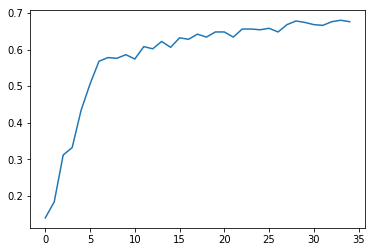

In [39]:
plt.plot(accuracies)

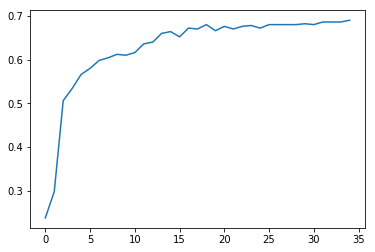

In [32]:
# Exercises:
# - Apply dropout between the LSTM and the linear layer
# - Add more complexity to the model (RNN layers, other layers)
# - Bidirectional RNN